# In The Mood For Love

Projeto inspirado pelo filme In The Mood For Love do diretor Wong Kar-Wai. 

In [ ]:
# 1. Achar momento do início e final do filme sem os creditos para não detectar cenas nesses momentos 
# Filme inteiro começa em 45 segundos e termina em 1h 32min 50s 

# 2. Ideia: pegar as cenas com meiores valores de vermelho e fazer edit com essas 
# Obs: só olhar rgb_mean e var não funciona muito bem. Várias cenas onde o valor de R é alto, G e B tambem são. 
# Não é um bom indicativo de clusterização. 
# Talvez essa seja uma boa comparação. 

# 3. Uma ideia era pegar o df final com coluna 'cluster' e fazer alguma coisa

# 4. Ideia: remover outliers de brilho e cor 

# 5. Adicionar parâmetro "highlight_name" para função de salvar video para definir nome do arquivo output final mp4 

In [5]:
import pandas as pd 
import numpy as np 

import os 
from pathlib import Path 

# Força CWD para o diretório raiz do projeto 
ROOT = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path().resolve().parent
os.chdir(ROOT)
print(f"Working directory set to: {ROOT}")

Working directory set to: /home/rafa/Documents/projects/git


In [7]:
from importlib import reload
import sys
sys.path.append('cinematic-data-clustering/src')
# sys.path.append('src')

import utils 
import scene_detection
import feature_extraction 
import visualization
import clustering 
import save_video

reload(utils)
reload(scene_detection)
reload(feature_extraction)
reload(visualization)
reload(clustering)
reload(save_video)

from utils import get_video_info, cut_scenes, from_root
from scene_detection import detect_scene_low_resolution
from feature_extraction import audio_features, extract_frames, image_features, movement_features
from visualization import plot_rms_silence, plot_color_features, plot_movement, plot_cluster_timeline, plot_scatter_umap, plot_scatter_pca
from clustering import clustering 
from save_video import write_top2_cluster_videos, write_video, write_all_clusters

/home/rafa/Documents/projects/git/cinematic-data-clustering/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
video_name = 'long' # snippet, long, fullMovie 
file_extension = '.mp4' 
video_file =  video_name + file_extension 

print(get_video_info(video_file)) 

df = pd.DataFrame() 
# df = detect_scene_low_resolution(video_file) 

{'duration': 549.215333, 'fps': 23.976023976023978, 'width': 3584, 'height': 2160, 'size_bytes': 1128533229}


In [38]:
# Cuts scenes that are too short or too long (optional) 
df_cut = cut_scenes(df, 2, 6) 
df = df_cut 

In [37]:
# Audio features: rms_mean and silence_ratio 
# df = audio_features(video_file, df) 

# Image features: HSV (hue, saturation, value) and RGB (red, green, blue) mean and variation 
df = extract_frames(video_file, df) 
df = image_features(df) 

# Movement features 
# df = movement_features(video_file, df) 

In [32]:
# df.to_csv(f'data/{video_name}.csv', index=False)
df = pd.read_csv(f'data/{video_name}.csv')

In [ ]:
# Escrevendo video com cenas com maiores valores de certas colunas com duração máxima estabelecida 

def write_biggest_values(df, col, max_duration):
        top_shots = df.nlargest(30, columns=col)

        selected_shots = [] 
        curr_duration = 0 

        for _, shot in top_shots.iterrows():
            if curr_duration + shot['duration'] < max_duration: 
                selected_shots.append(shot['shot_id']) 
                curr_duration += shot['duration']
                print(selected_shots)
            else: 
                continue 
        
        top_shots = df[df['shot_id'].isin(selected_shots)]
        write_video(top_shots, f'data/{video_name}_lowres.mp4', 20)

write_biggest_values(df, col=['r_mean', 'r_var'], max_duration=20)

In [ ]:
# Visualization of audio, image and movement features 

# plot_rms_silence(df) 
plot_color_features(df) 
# plot_movement(df) 

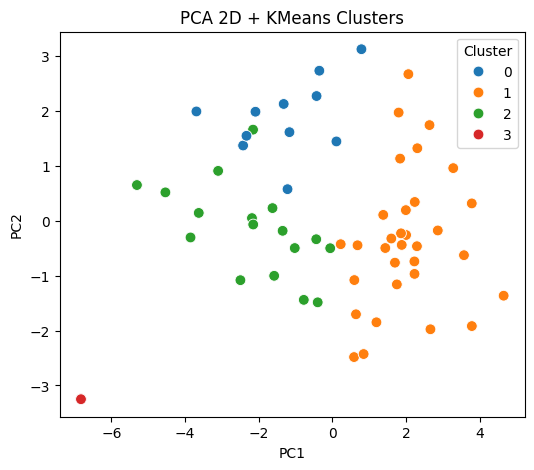

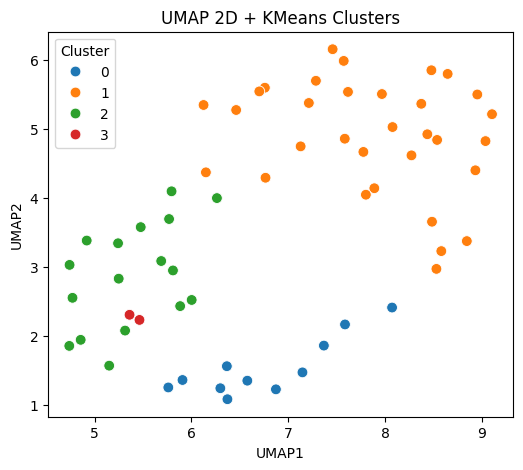

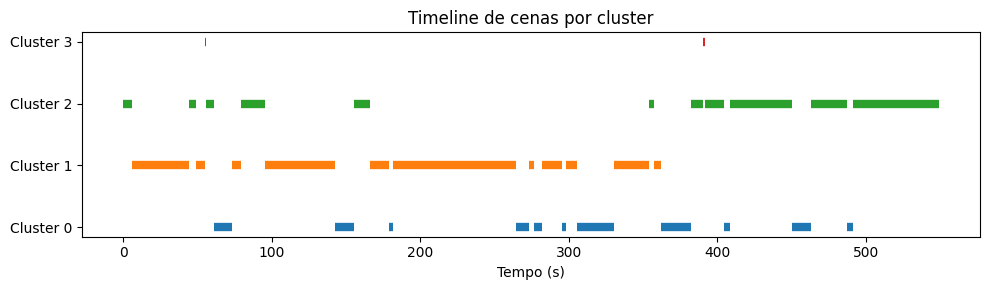

In [35]:
# df = clustering(df, video_name, method="dbscan", n_clusters=4)
df = clustering(df, video_name, n_clusters=4)

plot_scatter_pca(df) 
plot_scatter_umap(df) 

plot_cluster_timeline(df) 

In [ ]:
write_all_clusters(df, video_file=f"data/{video_file[:-4]}_lowres.mp4")

In [ ]:
write_top2_cluster_videos(
    df,
    video_file=f"data/{video_file[:-4]}_lowres.mp4",
    output_dir="data/highlight"
)